In [1]:
import tensorflow as tf
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, Add
from keras.layers import Input, Flatten, GlobalAveragePooling2D
from keras.models import Model
import math
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from keras import layers
import tensorflow_datasets as tfds
import pandas as pd

# Import the necessary callbacks
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, LearningRateScheduler

In [2]:
# setting the hyperparameters
image_size = 32
image_channels = 3
batch_size = 128
temperature = 0.1
epochs = 100
weight_decay = 1e-4
lr = 1e-1

In [3]:
classification_augmentation = {"min_area": 0.75}
ds_name = "svhn_cropped"

In [4]:
def prepare_dataset():

    train_dataset = (
        tfds.load(ds_name, split="train[:1%]", as_supervised=True, shuffle_files=True)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=10)
    )
    test_dataset = (
        tfds.load(ds_name, split="test", as_supervised=True)
        .cache()
        .batch(batch_size)
        .prefetch(buffer_size=10)
    )

    print("Number of training samples: %d" % tf.data.experimental.cardinality(train_dataset))
    print("Number of test samples: %d" % tf.data.experimental.cardinality(test_dataset))

    return train_dataset, test_dataset

In [5]:
# Load Cifar10 dataset
train_dataset,test_dataset = prepare_dataset()

Number of training samples: 6
Number of test samples: 204


In [6]:
# Image augmentation module
def get_augmenter(min_area):
    zoom_factor = 1.0 - math.sqrt(min_area)
    return keras.Sequential(
        [
            keras.Input(shape=(image_size, image_size, image_channels)),
            layers.Rescaling(1 / 255),
            layers.RandomFlip("horizontal"),
            layers.RandomTranslation(zoom_factor / 2, zoom_factor / 2),
            layers.RandomZoom((-zoom_factor, 0.0), (-zoom_factor, 0.0))
        ]
    )

In [7]:
def visualize_augmentations(num_images):
    # Sample a batch from a dataset
    images = next(iter(train_dataset))[0][:num_images]
    # Apply augmentations
    augmented_images = zip(
        images,
        get_augmenter(**classification_augmentation)(images),
    )
    row_titles = [
        "Original:",
        "Augmented Image:",
    ]
    plt.figure(figsize=(num_images * 2.2, 2 * 2.2), dpi=100)
    for column, image_row in enumerate(augmented_images):
        for row, image in enumerate(image_row):
            plt.subplot(2, num_images, row * num_images + column + 1)
            plt.imshow(image)
            if column == 0:
                plt.title(row_titles[row], loc="left")
            plt.axis("off")
    plt.tight_layout()

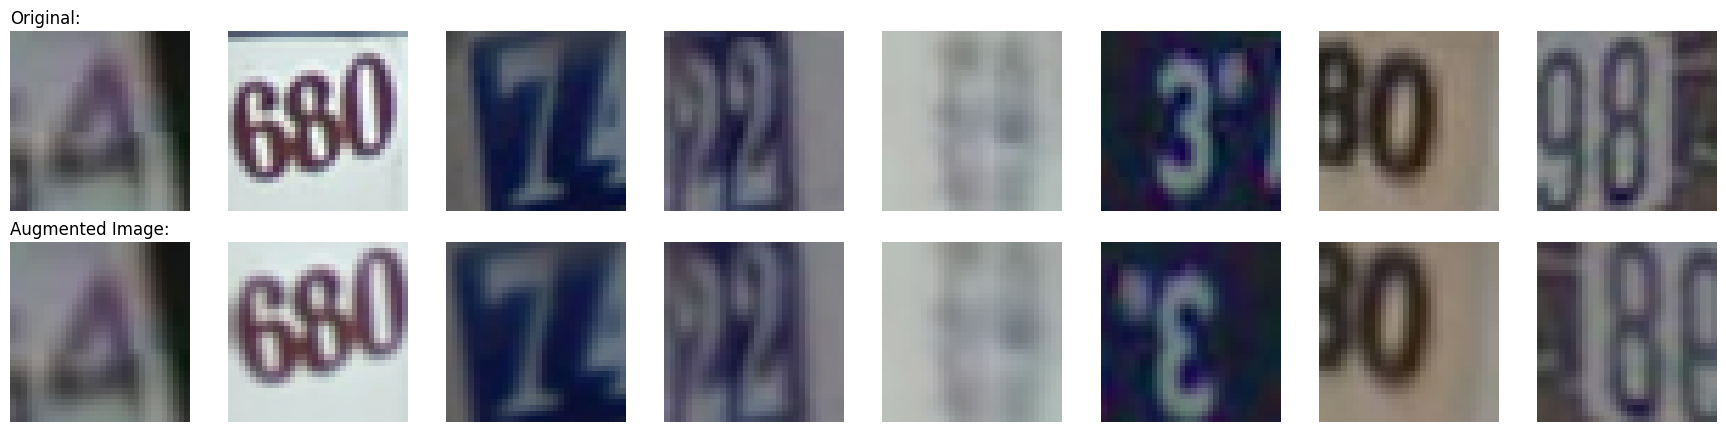

In [8]:
#Executing the visualizer
visualize_augmentations(num_images=8)

In [9]:
# Step 3: Define the ResNet-18 model
from keras import layers
from keras.layers import Dense
from keras.layers import Conv2D
from keras.layers import AveragePooling2D
from keras.layers import Flatten
from keras.layers import MaxPool2D
from keras.layers import Input
from keras.layers import BatchNormalization
from keras.layers import Activation
from keras.models import Model
from keras.regularizers import l2



def conv2d_bn(x, filters, kernel_size, strides=(1, 1)):
    layer = Conv2D(filters=filters,
                   kernel_size=kernel_size,
                   strides=strides,
                   padding='same'
                   )(x)
    layer = BatchNormalization()(layer)
    return layer

def conv2d_bn_relu(x, filters, kernel_size,  strides=(1, 1)):
    layer = conv2d_bn(x, filters, kernel_size,  strides)
    layer = Activation('relu')(layer)
    return layer

def ResidualBlock(x, filters, kernel_size,  downsample=True):
    if downsample:
        # residual_x = conv2d_bn_relu(x, filters, kernel_size=1, strides=2)
        residual_x = conv2d_bn(x, filters, kernel_size=1, strides=2)
        stride = 2
    else:
        residual_x = x
        stride = 1
    residual = conv2d_bn_relu(x,
                              filters=filters,
                              kernel_size=kernel_size,
                              
                              strides=stride,
                              )
    residual = conv2d_bn(residual,
                         filters=filters,
                         kernel_size=kernel_size,
                         
                         strides=1,
                         )
    out = layers.add([residual_x, residual])
    out = Activation('relu')(out)
    return out

def ResNet18(input_shape=(32, 32, 3)):
    input = Input(shape=input_shape)
    x = input
    # x = conv2d_bn_relu(x, filters=64, kernel_size=(7, 7), weight_decay=weight_decay, strides=(2, 2))
    # x = MaxPool2D(pool_size=(3, 3), strides=(2, 2),  padding='same')(x)
    x = conv2d_bn_relu(x, filters=64, kernel_size=(3, 3),  strides=(1, 1))

    # # conv 2
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3),  downsample=False)
    x = ResidualBlock(x, filters=64, kernel_size=(3, 3),  downsample=False)
    # # conv 3
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=128, kernel_size=(3, 3),  downsample=False)
    # # conv 4
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=256, kernel_size=(3, 3),  downsample=False)
    # # conv 5
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3),  downsample=True)
    x = ResidualBlock(x, filters=512, kernel_size=(3, 3),  downsample=False)
    x = AveragePooling2D(pool_size=(4, 4), padding='valid')(x)
    x = GlobalAveragePooling2D()(x)
    #x = Dense(classes, activation='softmax')(x)
    model = Model(input, x, name='ResNet18')
    return model

In [10]:
model = ResNet18()
model.load_weights('Test/Weights/positive_only.h5')
#model.trainable = False

In [11]:
model.summary()

Model: "ResNet18"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   1792        ['input_2[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 32, 32, 64)  256         ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                                  
 activation (Activation)        (None, 32, 32, 64)   0           ['batch_normalization[0][0

In [12]:
# Supervised finetuning of the pretrained encoder
finetuning_model = keras.Sequential(
    [
        layers.Input(shape=(image_size, image_size, image_channels)),
        get_augmenter(**classification_augmentation),
        model,
        layers.Dense(128, activation='relu'),
        layers.Dense(10, activation='softmax'),
    ],
    name="finetuning_model",
)
'''finetuning_model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss=keras.losses.SparseCategoricalCrossentropy(),
    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],
)'''

'finetuning_model.compile(\n    optimizer=keras.optimizers.Adam(0.001),\n    loss=keras.losses.SparseCategoricalCrossentropy(),\n    metrics=[keras.metrics.SparseCategoricalAccuracy(name="acc")],\n)'

In [13]:
optimizer = tf.keras.optimizers.SGD(learning_rate=0.1, momentum=0.9, nesterov=False)

finetuning_model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])

finetuning_model.summary()

Model: "finetuning_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_1 (Sequential)   (None, 32, 32, 3)         0         
                                                                 
 ResNet18 (Functional)       (None, 512)               11183232  
                                                                 
 dense (Dense)               (None, 128)               65664     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 11,250,186
Trainable params: 11,240,586
Non-trainable params: 9,600
_________________________________________________________________


In [14]:
finetuning_history = finetuning_model.fit(
    train_dataset, epochs= epochs , validation_data=test_dataset
)
print(
    "Maximal validation accuracy: {:.2f}%".format(
        max(finetuning_history.history['val_accuracy']) * 100
    )
)

Epoch 1/100
6/6 [==============================] - 13s 1s/step - loss: 2.8114 - accuracy: 0.1241 - val_loss: 2.3414 - val_accuracy: 0.1746
Epoch 2/100
6/6 [==============================] - 5s 898ms/step - loss: 2.2356 - accuracy: 0.2046 - val_loss: 2.3970 - val_accuracy: 0.1958
Epoch 3/100
6/6 [==============================] - 5s 909ms/step - loss: 2.1688 - accuracy: 0.2333 - val_loss: 2.3557 - val_accuracy: 0.1897
Epoch 4/100
6/6 [==============================] - 5s 905ms/step - loss: 2.0894 - accuracy: 0.2497 - val_loss: 2.4547 - val_accuracy: 0.1156
Epoch 5/100
6/6 [==============================] - 5s 901ms/step - loss: 2.0255 - accuracy: 0.2674 - val_loss: 2.4111 - val_accuracy: 0.1263
Epoch 6/100
6/6 [==============================] - 5s 902ms/step - loss: 1.9509 - accuracy: 0.3015 - val_loss: 2.4119 - val_accuracy: 0.1442
Epoch 7/100
6/6 [==============================] - 5s 905ms/step - loss: 1.8533 - accuracy: 0.3479 - val_loss: 2.4343 - val_accuracy: 0.1408
Epoch 8/100
6/6

In [15]:
acc = finetuning_history.history['accuracy']
val_acc = finetuning_history.history['val_accuracy']
loss = finetuning_history.history['loss']
val_loss = finetuning_history.history['val_loss']

In [16]:
# save the results to csv file
#df = pd.DataFrame({'acc':acc, 'val_acc':val_acc, 'loss':loss, 'val_loss':val_loss})
#df.to_csv('Test/Results/ft_pos_only_5%.csv', index=False)



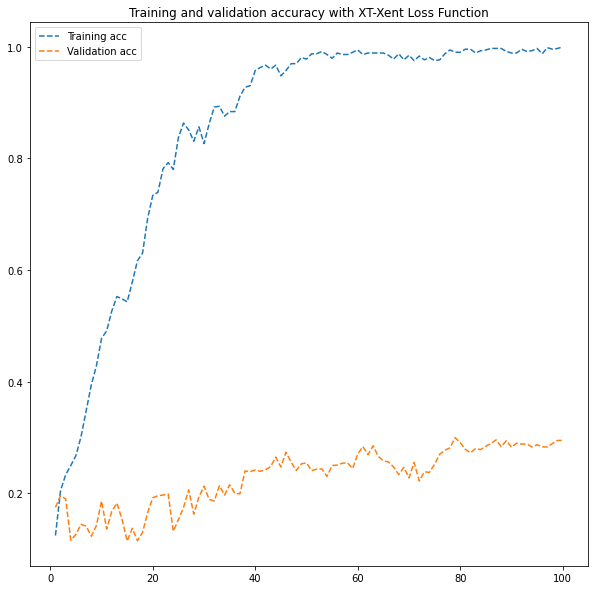

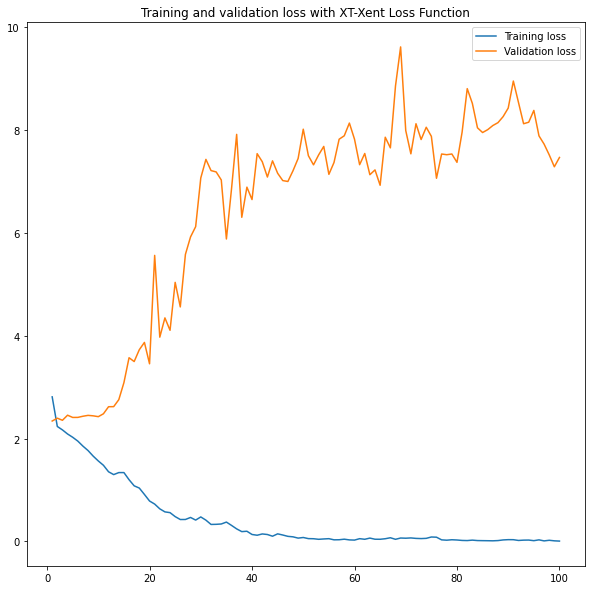

In [17]:
import matplotlib.pyplot as plt

epochs = range(1, len(acc) + 1)
plt.figure(figsize=(10, 10))

plt.plot(epochs, acc, '--', label='Training acc')
plt.plot(epochs, val_acc, '--', label='Validation acc')
plt.title('Training and validation accuracy with XT-Xent Loss Function')
plt.legend()

plt.figure(figsize=(10, 10))

plt.plot(epochs, loss, '-', label='Training loss')
plt.plot(epochs, val_loss, '-', label='Validation loss')
plt.title('Training and validation loss with XT-Xent Loss Function')
plt.legend()

plt.show()

## Confusion Matrix



In [18]:
import numpy as np

# Load images from extra dataset.
cm_datasets = tfds.load(ds_name, split="extra", as_supervised=True)

#images = next(iter(train_dataset))[0][:num_images]
test_images, test_labels = next(iter(cm_datasets.batch(50000)))
test_labels = test_labels.numpy()
#preditc the labels of the image batch
predictions = finetuning_model.predict(test_images)
# Convert predictions to class labels
predicted_labels = np.argmax(predictions, axis=1)

In [19]:
confusion_matrix = tf.math.confusion_matrix(test_labels, predicted_labels)

In [20]:
confusion_matrix = confusion_matrix.numpy()

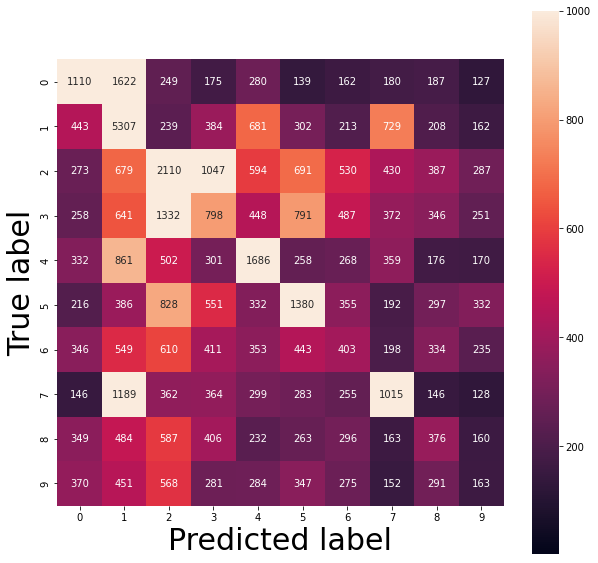

In [21]:
# Create and plot the heatmap
plt.figure(figsize=(10, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='d', cmap='rocket',vmin=1, vmax=1000, square=True, cbar=True)
plt.xlabel('Predicted label', fontsize=30)
plt.ylabel('True label', fontsize=30)
#plt.title('Modified Loss A + Finetuned (5%) SVHN datasets', fontsize=15,pad=20)
plt.show()

## Visual Representation

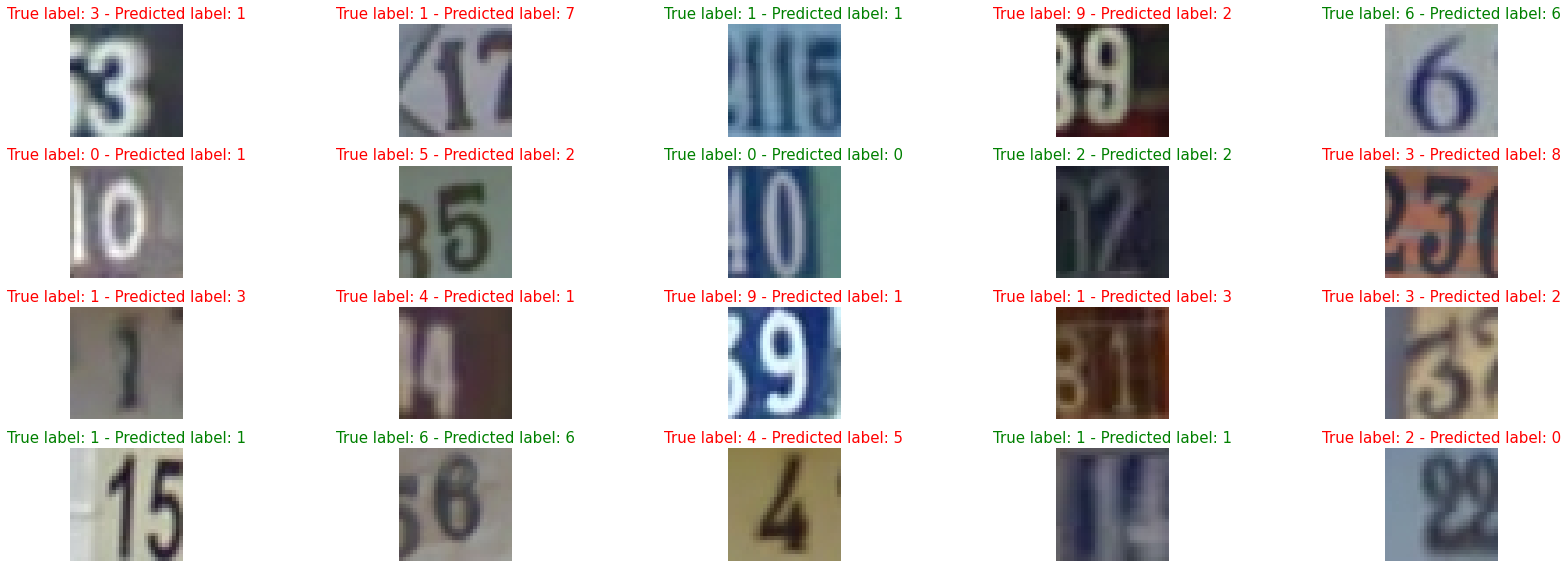

In [22]:
import matplotlib.pyplot as plt

# Create a 5 by 2 grid of subplots
fig, axes = plt.subplots(4, 5, figsize=(25, 8))

# Flatten the axes array to make it easier to loop over
axes = axes.flatten()

# Loop over the images and the axes
for i, (image, true_label, predicted_label, ax) in enumerate(zip(test_images, test_labels, predicted_labels, axes)):
    # Plot the image on the current axis
    ax.imshow(image)
    # Set the title with the true and predicted labels
    ax.set_title(f"True label: {true_label} - Predicted label: {predicted_label}", color=("green" if true_label == predicted_label else "red"), fontsize=15)
    # Turn off the axis ticks and labels
    ax.axis("off")

# Adjust the spacing between subplots
fig.tight_layout()

# Show the figure
plt.show()


## TSNE Result

In [23]:
Tsne_test_dataset = (
        tfds.load(ds_name, split="test", as_supervised=True)
        .batch(500)
        .cache()
        .prefetch(buffer_size=10)
    )

In [24]:
test_images_tsne, test_labels_tsne = next(iter(Tsne_test_dataset.take(1)))

In [25]:
features = finetuning_model.predict(test_images_tsne)

In [26]:
labels = tf.one_hot(test_labels_tsne, 10)

In [27]:
#import precision, recall, f1 score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import accuracy_score

precision, recall, fscore, support = score(labels, features.round(), average='macro')
accuracy = accuracy_score(labels, features.round())

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))

print('accuracy: {}'.format(accuracy))



precision: 0.24138546704955233
recall: 0.23460350139316746
fscore: 0.2291320578867048
accuracy: 0.28


In [28]:
import numpy as np
from sklearn.manifold import TSNE

In [29]:
tsne = TSNE().fit_transform(features)

d:\ProgramFiles\Anaconda\envs\My_Lab\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
d:\ProgramFiles\Anaconda\envs\My_Lab\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


In [30]:
tx, ty = tsne[:,0], tsne[:,1]
tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))

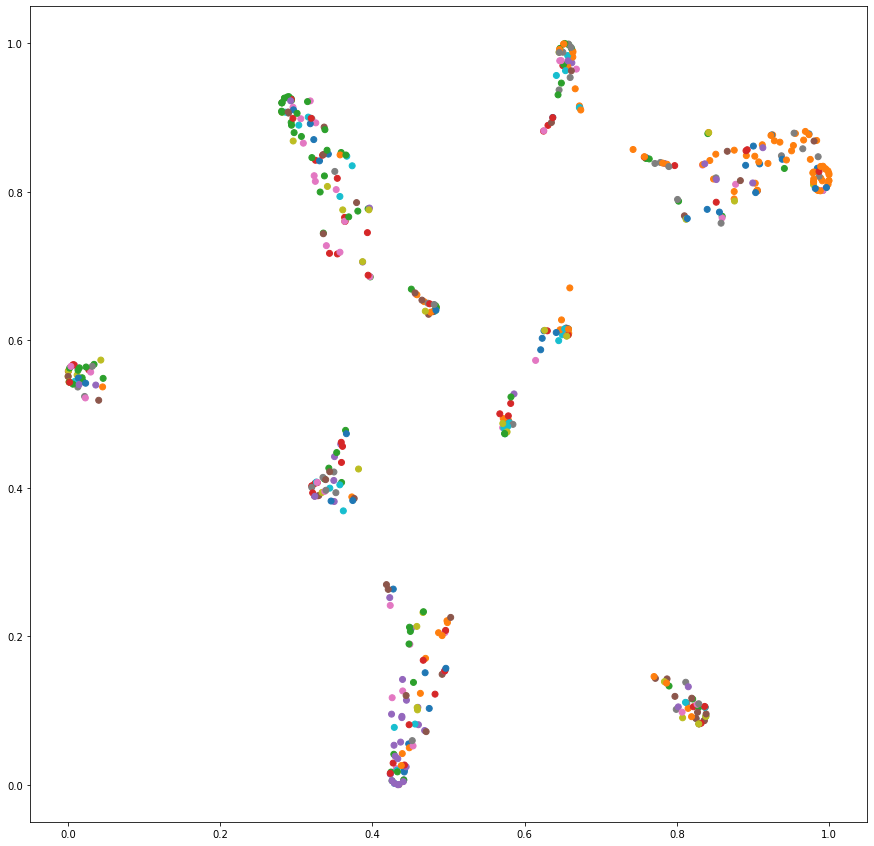

: 

In [31]:
plt.figure( figsize=(15,15) )
plt.scatter(tx,ty ,c=test_labels_tsne, cmap='tab10' )
plt.show()